# Project Description - Tools classification and localization using MobileNet

**Introduction** <br>
This is a project of tools classification/localization. There are 6 different classes:
- Cutter
- Tongs
- Screws_box
- Screwdriver
- Drill_bit
- Allen_keys

**Outline** <br>
This project will have the presentation outlined as follows,
1. Dataset visualization
2. Model training and validation
3. Model testing
4. Results evaluation
5. Model prediction

## Imports

In [ ]:
# Import necessary libraries

import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob
import random
from matplotlib.patches import Rectangle
from matplotlib import pyplot
from lxml import etree
from sklearn.model_selection import train_test_split #function to split a dataset
import shutil #library with function to copy files between folders
from sklearn.preprocessing import LabelBinarizer

# Enable Matplotlib backend for displaying static images
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PATH = '/content/sample_data/Data/'

El fichero Data.zip contiene:


*   Data: una carpeta "images" para todos los jpg y otra "annotations" para los xml (con nombres iguales)
*   Test: una carpeta con todos los jpg y xml



In [ ]:
os.makedirs(PATH, exist_ok=True)

!unzip -q '/content/drive/MyDrive/Colab Notebooks/Computer Vision course/DL/03a - SingleDetection-Tools/Data/Data.zip' -d '/content/sample_data/Data'

In [ ]:
# Inspect Data, there are 100 images for each of the 6 classes, for a total of 600.

images_names = os.listdir(PATH+'images')
print('Total images: ', len(images_names))
xml_names = os.listdir(PATH+'Annotations')
print('Total annotations: ', len(xml_names))

SIZE = 224

Total images:  600
Total annotations:  600


## Divide data into train, valid and test folders

In [ ]:
# Function to extract the class of the image from the annotation file
def get_class(path):
    # Read the annotation file

    data = open(path, 'rb')

    xslt_content = data.read()
    sel = etree.XML(xslt_content)

    # Extract class
    label = str(sel.xpath("//object/name/text()")[0])

    return label

In [ ]:
# Create folders to Data and Models
try:
    os.makedirs(PATH+'Data', exist_ok=True)
    os.makedirs(PATH+'Models', exist_ok=True)
    os.makedirs(PATH+'Data/Train', exist_ok=True)
    os.makedirs(PATH+'Data/Test', exist_ok=True)
    os.makedirs(PATH+'Data/Valid', exist_ok=True)
except:
    print('Error creating folders')

# Define path to folders
path_images = PATH+'images'
path_xml = PATH+'Annotations'
path_train = PATH+'Data/Train'
path_test = PATH+'Data/Test'
path_valid = PATH+'Data/Valid'
path_models = PATH+'Models'

# Get the class of each image
elements = []

for item in xml_names:
    name = item
    label = get_class(os.path.join(path_xml,item))
    elements.append([name,label])

# Convert elements inta a pandas dataframe, and get class labels
df = pd.DataFrame(elements, columns=['name','label'])
labels = df['label'].unique()

# Create class dictionary
Class_dict = dict(zip(labels, range(1,len(labels) + 1)))

# Obtain a dataset for each class
# This serves later on for making the split in each class
list_df = []
for label in labels:
    list_df.append('df_'+label)

for i in range(len(labels)):
    list_df[i] = df[df['label'] == labels[i]]

# Example with class 0
list_df[0]

,name,label
0,d773edcb-cutter1296.xml,cutter
2,392469dc-cutter328.xml,cutter
5,e3d7f34e-cutter416.xml,cutter
12,7b2dde05-cutter1256.xml,cutter
18,168f71d4-cutter1280.xml,cutter
...,...,...
535,e836a3d7-cutter148.xml,cutter
547,36dbd010-cutter1312.xml,cutter
560,628d3db1-cutter528.xml,cutter
572,bfb2934f-cutter56.xml,cutter


In [ ]:
labels

array(['cutter', 'tongs', 'screws_box', 'screwdriver', 'drill_bit',
       'allen_keys'], dtype=object)

In [ ]:
# Delete items in train, valid and test folders
for the_file in os.listdir(path_train):
    file_path = os.path.join(path_train,the_file)
    os.remove(file_path)

for the_file in os.listdir(path_valid):
    file_path = os.path.join(path_valid,the_file)
    os.remove(file_path)

for the_file in os.listdir(path_test):
    file_path = os.path.join(path_test,the_file)
    os.remove(file_path)

# Divide each class dataset in 3 parts, and copy images and annotations to corresponding folder
for dataset in list_df:
    train, aux = train_test_split(dataset,test_size=0.3, random_state=17)
    test, valid = train_test_split(aux, test_size = 0.5, random_state=7)

    for item in train['name']:
        shutil.copy(os.path.join(path_xml,item), os.path.join(path_train,item))
        shutil.copy(os.path.join(path_images,item[:-4]+'.jpg'),os.path.join(path_train,item[:-4]+'.jpg'))


    for item in test['name']:
        shutil.copy(os.path.join(path_xml,item), os.path.join(path_test,item))
        shutil.copy(os.path.join(path_images,item[:-4]+'.jpg'),os.path.join(path_test,item[:-4]+'.jpg'))

    for item in valid['name']:
        shutil.copy(os.path.join(path_xml,item), os.path.join(path_valid,item))
        shutil.copy(os.path.join(path_images,item[:-4]+'.jpg'),os.path.join(path_valid,item[:-4]+'.jpg'))

## Create datasets

In [ ]:
# Function to parse and extract information from annotation files

def get_annotations(path):
    # Read the annotation file

    data = open(path, 'rb')

    xslt_content = data.read()
    sel = etree.XML(xslt_content)

    # Obtain the image width
    width = int(sel.xpath("//size/width/text()")[0])
    # Obtain the image height
    height = int(sel.xpath("//size/height/text()")[0])
    # Extract the bounding box coordinates (numbers)
    xmin = int(sel.xpath("//bndbox/xmin/text()")[0])
    xmax = int(sel.xpath("//bndbox/xmax/text()")[0])
    ymin = int(sel.xpath("//bndbox/ymin/text()")[0])
    ymax = int(sel.xpath("//bndbox/ymax/text()")[0])
    # Extract class (string)
    label = str(sel.xpath("//object/name/text()")[0])
    # Return the relative coordinates
    return [xmin/width, ymin/height, xmax/width, ymax/height,label]

def get_list_annotations(path_folder):

    items = os.listdir(path_folder)
    items.sort()
    xml = []

    for item in items:
        if item[-4:] == '.xml':
            xml.append(os.path.join(path_folder,item))

    return [get_annotations(path) for path in xml]

In [ ]:
train_coors = get_list_annotations(path_train)
test_coors = get_list_annotations(path_test)
valid_coors = get_list_annotations(path_valid)

In [ ]:
def one_hot_label(label, Class_dict):
    '''
    function to obtain a one-hot vector of classes for each label

    inputs:
    label: list with the labels of the images
    Class_dict: dictionary of the classes labels
    '''

    # Create a pandas dataset with the labels
    labels = pd.DataFrame(label, columns = ["Label"])
    # Add a column with numbers corresponding to each class in the Class dict
    labels["Class"] = labels["Label"].apply(lambda x: Class_dict[x])

    lb = LabelBinarizer()
    # Fit label binarizer
    lb.fit(list(Class_dict.values()))
    # Convert multi-class labels to binary labels (belong or does not belong to the class)
    transformed_labels = lb.transform(labels["Class"])
    y_bin_labels = []

    for i in range(transformed_labels.shape[1]):
        y_bin_labels.append("Class" + str(i))
        labels["Class" + str(i + 1)] = transformed_labels[:, i]

    labels.drop("Label", axis = 1, inplace = True)
    labels.drop("Class", axis = 1, inplace = True)

    return labels

In [ ]:
def load_image(path, size):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image,3)
    image = tf.image.resize(image,[size,size])
    image = tf.cast(image,tf.float32)
    image = image / 255.

    return image

def create_dataset(coors, path, batch, Class_dict, size):
    # zip agrupa los ith elementos de cada lista y los convierte en lista
    xmin, ymin, xmax, ymax, label = list(zip(*coors))

    # Si quisieramos codificación one-hot (con loss "categorical")
    # labels = one_hot_label(label, Class_dict)
    labels = [Class_dict[a]-1 for a in label]

    # Convert to Numpy array
    xmin = np.array(xmin)
    ymin = np.array(ymin)
    xmax = np.array(xmax)
    ymax = np.array(ymax)
    label = np.array(labels)

    labels_dataset = tf.data.Dataset.from_tensor_slices((xmin, ymin, xmax, ymax, label))

    imgs = []
    listSorted = os.listdir(path)
    listSorted.sort()

    for i in listSorted:
        if i[-4:] == '.jpg':
            imgs.append(os.path.join(path,i))

    dataset = tf.data.Dataset.from_tensor_slices(imgs)
    dataset = dataset.map(lambda path: load_image(path, size))

    dataset_label = tf.data.Dataset.zip((dataset, labels_dataset))

    dataset_label = dataset_label.shuffle(64).batch(batch)

    AUTOTUNE = tf.data.experimental.AUTOTUNE

    dataset_label = dataset_label.cache().prefetch(buffer_size=AUTOTUNE)

    return dataset_label

In [ ]:
batch_train = 16
batch_valid = 4

# con repeat(), los datos se repetirán indefinidamente
train_dataset = create_dataset(train_coors,path_train, batch_train, Class_dict, SIZE).repeat()
test_dataset = create_dataset(test_coors,path_test, batch_valid, Class_dict, SIZE)
valid_dataset = create_dataset(valid_coors,path_valid, batch_valid, Class_dict, SIZE)

In [ ]:
dict_labels = list(Class_dict.keys())
dict_labels

['cutter', 'tongs', 'screws_box', 'screwdriver', 'drill_bit', 'allen_keys']

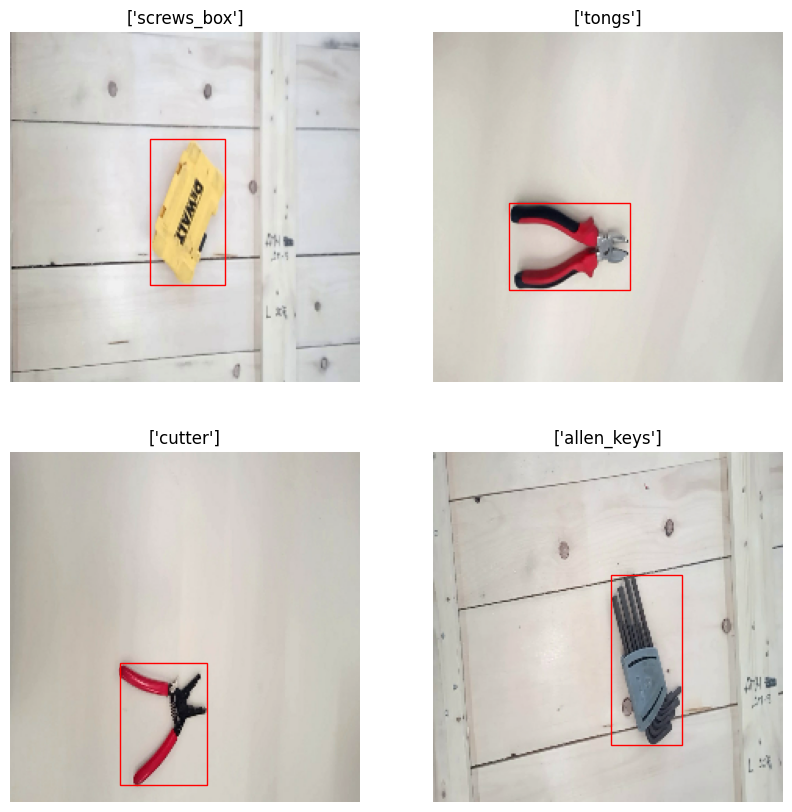

In [ ]:
# Display a sample training image with its label
pyplot.figure(figsize=(10, 10))

for img,label in test_dataset.take(1):
  out1, out2, out3, out4, out5 = label

  for i in range(4):

    ax = pyplot.subplot(2, 2, i + 1)
    plt.imshow(keras.preprocessing.image.array_to_img(img[i]))

    xmin, ymin, xmax, ymax = out1[i].numpy()*SIZE, out2[i].numpy()*SIZE, out3[i].numpy()*SIZE, out4[i].numpy()*SIZE
    rect = Rectangle((xmin,ymin),(xmax - xmin),(ymax - ymin), fill = False, color = "r")
    ax = plt.gca()
    ax.axes.add_patch(rect)
    plt.title([clave for clave, valor in Class_dict.items() if valor == out5[i]+1])
    pyplot.axis("off")

    #plt.show()

## Define model architecture

In [ ]:
# Import MobileNetV2 model with pre-trained weights from ImageNet

base = tf.keras.applications.MobileNetV2(weights = "imagenet",
                                         include_top = False,
                                         input_shape = (SIZE,SIZE,3),
                                         pooling = 'avg')

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
# Train only  fully-connected layers
base.trainable = False

In [ ]:
# Define the base model with fully-connected layers
inputs = keras.Input(shape = (SIZE,SIZE,3))
x = base(inputs)

x1 = keras.layers.Dense(512, activation = "relu")(x)
x1 = keras.layers.Dense(256, activation = "relu")(x1)

out1 = keras.layers.Dense(128, activation = "relu")(x1)
out1 = keras.layers.Dense(1, name = "xmin")(out1)

out2 = keras.layers.Dense(128, activation = "relu")(x1)
out2 = keras.layers.Dense(1, name = "ymin")(out2)

out3 = keras.layers.Dense(128, activation = "relu")(x1)
out3 = keras.layers.Dense(1, name = "xmax")(out3)

out4 = keras.layers.Dense(128, activation = "relu")(x1)
out4 = keras.layers.Dense(1, name = "ymax")(out4)

x2 = keras.layers.Flatten()(x)
x2 = keras.layers.Dense(1024,activation = "relu")(x2)
x2 = keras.layers.Dense(512,activation = "relu")(x2)
out_class = keras.layers.Dense(6,activation = "softmax", name = "class")(x2)

out = [out1, out2, out3, out4, out_class]

model = keras.models.Model(inputs = inputs, outputs = out)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 mobilenetv2_1.00_224 (Func  (None, 1280)                 2257984   ['input_2[0][0]']             
 tional)                                                                                          
                                                                                                  
 dense (Dense)               (None, 512)                  655872    ['mobilenetv2_1.00_224[0][0]']
                                                                                                  
 flatten (Flatten)           (None, 1280)                 0         ['mobilenetv2_1.00_224[0][

## Compile and train

In [ ]:
# Compile the model with optimizer and loss functions
# 16 loss metrics and 16 valid metrics
# 5 neurons x 2 metrics = 10 + 6 loss metrics (5 + global loss)
model.compile(keras.optimizers.Adam(0.1),
              loss = {"xmin": "mse",
                      "ymin": "mse",
                      "xmax": "mse",
                      "ymax": "mse",
                      "class": "sparse_categorical_crossentropy"},
              metrics = ["mae","acc"])

In [ ]:
# callback to save the best model (looking at the best possible accuracy in validation data)
cb1 = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(path_models,'MN_loc.h5'), monitor='val_loss', verbose=0, save_best_only=True,
    save_weights_only=False, mode='min', save_freq='epoch'
    )

cb2 = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.001, patience=50, verbose=0, mode='min',
    baseline=None, restore_best_weights=True
    )

In [ ]:
train_items = len(os.listdir(path_train))/2
valid_items = len(os.listdir(path_valid))/2

# Start training the model
history = model.fit(train_dataset,
                    steps_per_epoch = train_items//batch_train,
                    batch_size=batch_train,
                    epochs = 100,
                    validation_data = valid_dataset,
                    validation_steps = valid_items//batch_valid,
                    callbacks=[cb1,cb2])

Epoch 1/100
25/26 [===========================>..] - ETA: 0s - loss: 870.3028 - xmin_loss: 285.3000 - ymin_loss: 180.3512 - xmax_loss: 152.9782 - ymax_loss: 222.2422 - class_loss: 29.4312 - xmin_mae: 4.1683 - xmin_acc: 0.0000e+00 - ymin_mae: 3.5365 - ymin_acc: 0.0300 - xmax_mae: 3.5409 - xmax_acc: 0.0000e+00 - ymax_mae: 3.6957 - ymax_acc: 0.0000e+00 - class_mae: 2.4050 - class_acc: 0.6075

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


26/26 [==============================] - 12s 109ms/step - loss: 837.0438 - xmin_loss: 274.3282 - ymin_loss: 173.4159 - xmax_loss: 147.0956 - ymax_loss: 213.6957 - class_loss: 28.5084 - xmin_mae: 4.0143 - xmin_acc: 0.0000e+00 - ymin_mae: 3.4059 - ymin_acc: 0.0288 - xmax_mae: 3.4109 - xmax_acc: 0.0000e+00 - ymax_mae: 3.5594 - ymax_acc: 0.0000e+00 - class_mae: 2.3886 - class_acc: 0.6058 - val_loss: 5.6848 - val_xmin_loss: 0.0261 - val_ymin_loss: 0.0385 - val_xmax_loss: 0.0368 - val_ymax_loss: 0.0509 - val_class_loss: 5.5326 - val_xmin_mae: 0.1211 - val_xmin_acc: 0.0000e+00 - val_ymin_mae: 0.1622 - val_ymin_acc: 0.0227 - val_xmax_mae: 0.1600 - val_xmax_acc: 0.0000e+00 - val_ymax_mae: 0.1865 - val_ymax_acc: 0.0000e+00 - val_class_mae: 2.3977 - val_class_acc: 0.7727
Epoch 2/100
26/26 [==============================] - 1s 56ms/step - loss: 11.8661 - xmin_loss: 0.0177 - ymin_loss: 0.0419 - xmax_loss: 0.0139 - ymax_loss: 0.0410 - class_loss: 11.7516 - xmin_mae: 0.1085 - xmin_acc: 0.0000e+00 - y

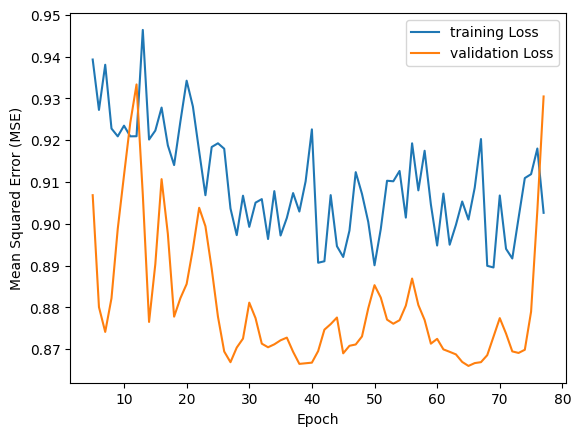

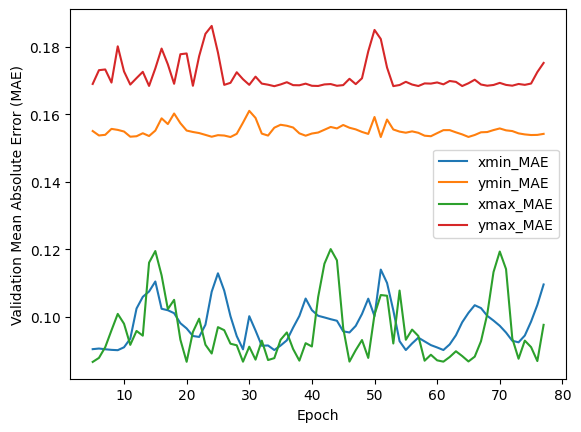

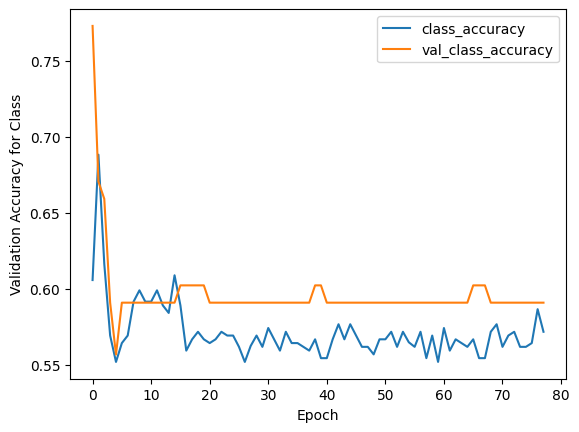

In [ ]:
# Visualize the results after training
flag = 5

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist["epoch"] = history.epoch

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Mean Squared Error (MSE)")
    plt.plot(hist["epoch"][flag:], hist["loss"][flag:], label = "training Loss")
    plt.plot(hist["epoch"][flag:], hist["val_loss"][flag:], label = "validation Loss")
    plt.legend()

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Validation Mean Absolute Error (MAE)")
    plt.plot(hist["epoch"][flag:], hist["val_xmin_mae"][flag:], label = "xmin_MAE")
    plt.plot(hist["epoch"][flag:], hist["val_ymin_mae"][flag:], label = "ymin_MAE")
    plt.plot(hist["epoch"][flag:], hist["val_xmax_mae"][flag:], label = "xmax_MAE")
    plt.plot(hist["epoch"][flag:], hist["val_ymax_mae"][flag:], label = "ymax_MAE")
    plt.legend()

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Validation Accuracy for Class")
    plt.plot(hist["epoch"],hist["class_acc"], label = "class_accuracy")
    plt.plot(hist["epoch"],hist["val_class_acc"], label = "val_class_accuracy")
    plt.legend()

    plt.show()

plot_history(history)

## Model evaluation

In [ ]:
test_items = len(os.listdir(path_test))/2

results = model.evaluate(test_dataset, steps = test_items/batch_valid)

22/22 [==============================] - 0s 16ms/step - loss: 0.9392 - xmin_loss: 0.0145 - ymin_loss: 0.0323 - xmax_loss: 0.0130 - ymax_loss: 0.0334 - class_loss: 0.8460 - xmin_mae: 0.0990 - xmin_acc: 0.0000e+00 - ymin_mae: 0.1493 - ymin_acc: 0.0111 - xmax_mae: 0.0929 - xmax_acc: 0.0000e+00 - ymax_mae: 0.1520 - ymax_acc: 0.0000e+00 - class_mae: 2.3889 - class_acc: 0.5556


In [ ]:
# Order (it can be seen in the training):
# These 3 groups only appears in the training
# - loss, xmin_loss, ymin_loss, xmax_loss, ymax_loss, class_loss
# - xmin_mae, xmin_acc, ymin_mae, ymin_acc, xmax_mae, xmax_acc, ymax_mae, ymax_acc
# - class_mae, class_acc

# - val_loss, val_xmin_loss, val_ymin_loss, val_xmax_loss, val_ymax_loss, val_class_loss
# - val_xmin_mae, val_xmin_acc, val_ymin_mae, val_ymin_acc, val_xmax_mae, val_xmax_acc, val_ymax_mae, val_ymax_acc
# - val_class_mae, val_class_acc
print("MAE of xmin value in test set:{}".format(results[6]))
print("MAE of ymin value in test set:{}".format(results[8]))
print("MAE of xmax value in test set:{}".format(results[10]))
print("MAE of ymax value in test set:{}".format(results[12]))
print("Testing accuracy of predicted label:{}".format(results[15]))

MAE of xmin value in test set:0.09895259141921997
MAE of ymin value in test set:0.14925159513950348
MAE of xmax value in test set:0.09292689710855484
MAE of ymax value in test set:0.15199095010757446
Testing accuracy of predicted label:0.5555555820465088


1/1 [==============================] - 1s 832ms/step


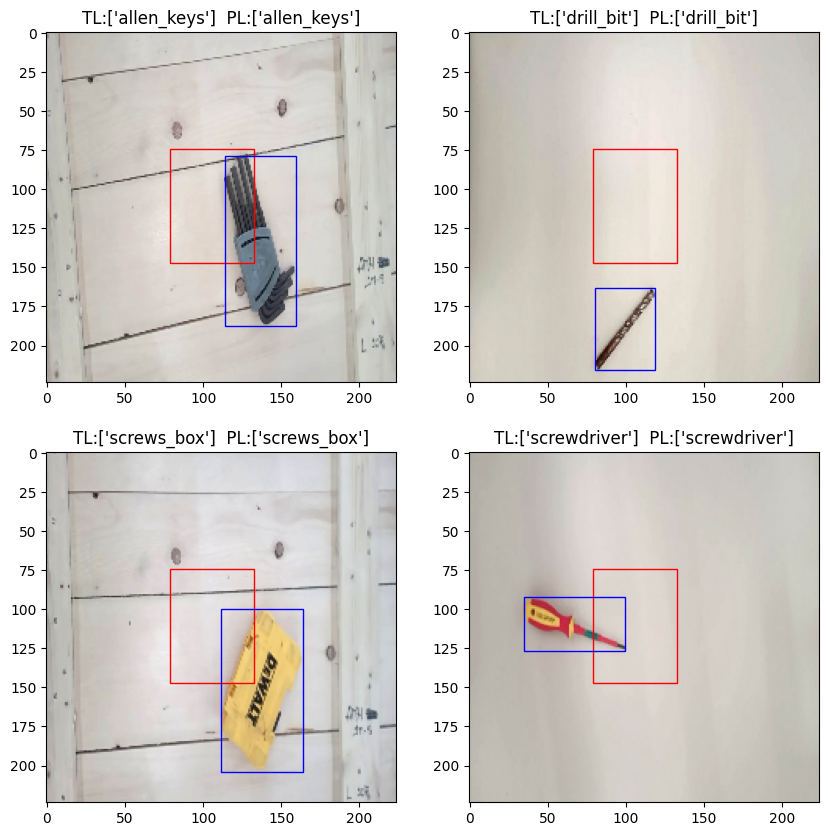

In [ ]:
# BLUE rectangle is ground truth
# RED rectangle is the prediction

plt.figure(figsize = (10,10))

for img, GT in test_dataset.take(1):
    out1, out2, out3, out4, out5 = model.predict(img)
    out1_gt, out2_gt, out3_gt, out4_gt, out5_gt = GT


    for i in range(4):

        plt.subplot(2, 2, i + 1)
        plt.imshow(keras.preprocessing.image.array_to_img(img[i]))

        plt.title('TL:{0}  PL:{1}'.format([clave for clave, valor in Class_dict.items() if valor == out5_gt[i]+1], [clave for clave, valor in Class_dict.items() if valor == np.argmax(out5[i])+1]))

        xmin, ymin, xmax, ymax = out1[i]*SIZE, out2[i]*SIZE, out3[i]*SIZE, out4[i]*SIZE
        rect = Rectangle((xmin,ymin), (xmax - xmin), (ymax - ymin), fill = False, color = "r")

        xmin, ymin, xmax, ymax = out1_gt[i]*SIZE, out2_gt[i]*SIZE, out3_gt[i]*SIZE, out4_gt[i]*SIZE
        rect2 = Rectangle((xmin,ymin), (xmax - xmin), (ymax - ymin), fill = False, color = "b")

        ax = plt.gca()
        ax.axes.add_patch(rect)
        ax.axes.add_patch(rect2)

## LOCALIZATION IS NOT GOOD

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def tecnun_report_loc(model, dataframe, dict_labels):

    true_labels, pred_labels = [], []
    for image, label in dataframe:
        _,_,_,_, out5 = label
        _,_,_,_, pred = model.predict(image, verbose=0)
        for element in out5:
            true_labels.append(dict_labels[element])
        for element in pred:
            pred_labels.append(dict_labels[np.argmax(element)])

    print(classification_report(true_labels, pred_labels))


def tecnun_matrix_loc(model, dataframe, dict_labels):

    true_labels, pred_labels = [], []
    for image, label in dataframe:
        _,_,_,_, out5 = label
        _,_,_,_, pred = model.predict(image, verbose=0)
        for element in out5:
            true_labels.append(dict_labels[element])
        for element in pred:
            pred_labels.append(dict_labels[np.argmax(element)])

    cf = confusion_matrix(true_labels, pred_labels, labels= dict_labels)

    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(cf, annot=True, fmt="", square=True, cbar=False,
              cmap=plt.cm.Blues, xticklabels=dict_labels, yticklabels=dict_labels, ax = ax)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_title('Confusion Matrix')
    plt.show()

In [ ]:
tecnun_report_loc(model, test_dataset, dict_labels)

              precision    recall  f1-score   support

  allen_keys       1.00      1.00      1.00        15
      cutter       0.00      0.00      0.00        15
   drill_bit       0.27      1.00      0.43        15
 screwdriver       1.00      0.33      0.50        15
  screws_box       1.00      1.00      1.00        15
       tongs       0.00      0.00      0.00        15

    accuracy                           0.56        90
   macro avg       0.55      0.56      0.49        90
weighted avg       0.55      0.56      0.49        90



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


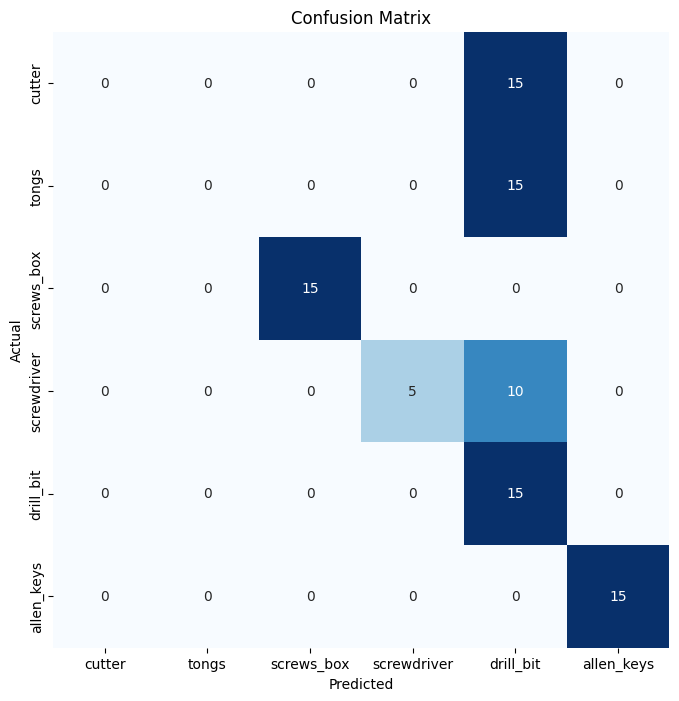

In [ ]:
tecnun_matrix_loc(model, test_dataset, dict_labels)